### Inference Analysis



# Proposal of baseline scores: 

Option 1: 
I propose giving an average on the three images (n_predictions =3) as the baseline dice score as option one
so, you make the average of the scores of n_predictions = 3 or try finding out with other numbers
##found in last cell in effect of support set sizes


Option 2: 
Do the same but adding ensembling. 
##found at the end of this file


In [67]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import itertools
import math
import einops as E
import pathlib
import os
import subprocess
from dataclasses import dataclass
from typing import Literal, Optional, Tuple
from torch.utils.data import Dataset
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [108]:
    # Define input and mask folders for the JNU_FMI dataset
test_input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\images\test'
test_mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\test'

support_input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\images\train'
support_mask_folder =  r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\train'

low_brightness_train_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\example_data\low_brigthness\train'
low_brightness_test_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\example_data\low_brigthness\test'


In [69]:


current_directory = os.getcwd()
print("Current directory:", current_directory)

# Get the current directory
current_directory = os.getcwd()

# List the contents of the current directory
contents = os.listdir(current_directory)

# Print the contents
print("Contents of the current directory:")
for item in contents:
    print(item)


Current directory: C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\UniverSeg-main\UniverSeg-main\universeg
Contents of the current directory:
.ipynb_checkpoints
Baseline using Universeg.ipynb
baseline_accuracy.csv
baseline_dicescore.csv
baseline_jaccard.csv
baseline_precision.csv
baseline_sensitivity.csv
inference_analysis - Copy.ipynb
inference_analysis.ipynb
label_path
model.py
nn
training.py
universeg_scratch.py
validation.py
__init__.py
__pycache__


In [70]:
# !git clone https://github.com/JJGO/UniverSeg
# !python -m pip install -r ./UniverSeg/requirements.txt
# # Add package directory to path
#!pip install torch


import torch
from model import universeg

# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'



# Instantiate the model and move it to the device
model = universeg(pretrained=True)
model.to(device)



UniverSeg(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (enc_blocks): ModuleList(
    (0): CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
      (support): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlin): LeakyReLU(negative_slope=0.01)
        )
      )
    )
    (1-3): 3 x CrossBlock(
      (cross): CrossOp(
        (cross_conv): CrossConv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (target): Vmap(
        (vmapped): ConvOp(
          (conv): Conv2d(64, 64, kernel_si

In [71]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Move the model to the GPU
    device = torch.device('cuda')
    model.to(device)
    print("Model moved to CUDA (GPU)")
else:
    print("CUDA is not available. Model remains on CPU.")


Model moved to CUDA (GPU)


In [72]:
#torch.cuda.get_arch_list()

### funtions for processing images 


### creating bounding boxes


#dice score 30

In [74]:
import PIL
import numpy as np
import pathlib
from typing import Tuple

import PIL
import numpy as np
import pathlib
from typing import Tuple

def process_image(image_path: pathlib.Path, seg_mask_path: pathlib.Path, size: Tuple[int, int], augment: bool = False) -> np.ndarray:
    """Process input image with hot encoded selection of areas."""
    # Load input image
    img = PIL.Image.open(image_path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")
    img = np.array(img)
    img = img.astype(np.float32)
    return img
#     



def process_seg(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = seg.convert("L")
    seg = np.array(seg)

    # One-hot encoded representation of segmentation mask
    #seg_mask = np.stack([seg == 0, seg == 128, seg == 255])
    seg = np.expand_dims(seg > 0, axis=0)
    seg = seg.astype(np.float32)

    return seg

def apply_rois(image: np.ndarray, seg_mask: np.ndarray) -> np.ndarray:
    """Apply regions of interest (ROIs) from segmentation mask to input image."""
    # Apply the mask to the input image
    img_with_rois = np.where(seg_mask[0], image, 0)
    img_with_rois = img_with_rois.astype(np.float32)



    return img_with_rois

import cv2





# img_path = pathlib.Path("C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\partitioned_dataset\\images\\test\\20190830T115515_269.png")
# seg_mask_path = pathlib.Path("C:\\Users\\cinth\\Documentos\\ams\\data_science\\actual_thesis\\codes\\UniverSeg-main\\UniverSeg-main\\example_data\\partitioned_dataset\\masks\\test\\20190830T115515_269_mask.png")

# # Process input image with hot encoded selection of areas
# processed_img = process_image(img_path, seg_mask_path, size=(128, 128), augment=False)
# import matplotlib.pyplot as plt
# 
# # Print the processed image
# plt.imshow(processed_img, cmap='gray')
# plt.axis('off')
# plt.show()



### convex hull

### load dataset correct

### with rois

In [76]:
def load_dataset(input_folder: str, mask_folder: str, size: Tuple[int, int] = (128, 128)):
    """Load dataset from input and mask folders."""
    data = []
    input_path = pathlib.Path(input_folder)
    mask_path = pathlib.Path(mask_folder)

    # Sort images based on numerical values in filenames
    input_files = sorted(input_path.glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
        

    for file in input_files:
        img = process_image(file,mask_path, size=size)
        img_name = file.stem

        # Load segmentation mask
        seg_file = mask_path / f"{img_name}_mask.png"
        if seg_file.exists():
            seg = process_seg(seg_file, size=size)
        else:
            print(f"Mask file '{seg_file}' not found. Skipping.")
            continue

        # Apply regions of interest (ROIs) to input image
        #img_with_co = img_with_convex_hull(img, seg)

        data.append((img / 255.0, seg))

    return data


In [112]:
from dataclasses import dataclass
from typing import Optional, Tuple, Literal
import os
import torch
import pathlib
import numpy as np
import PIL.Image
from torch.utils.data import Dataset

@dataclass
class JNU_FMI:
    input_folder: str
    label: str
    size: Tuple[int, int] = (128, 128)
    label_name: Optional[Literal["head", "symp", "background"]] = None
    
    def __post_init__(self):
        self._data = load_dataset(self.input_folder, self.label, size=self.size)
        self.filenames = sorted(pathlib.Path(self.input_folder).glob("*.png"), key=lambda x: int(x.stem.split('_')[-1]))
        T = torch.from_numpy
        
        # Assign indices based on sorted filenames
        self._data = [(T(x)[None], T(y)) for x, y in self._data]
         
        
        if self.label is not None:
            self.masks = sorted(os.listdir(self.label), key=lambda x: int(x.split('_')[-2]))
            if self.label in self.masks:
                self._ilabel = {"head": 1, "symp": 2, "background": 0}[self.label]
        
        self.idxs = list(range(len(self._data)))
        
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, idx):
        img, seg = self._data[self.idxs[idx]]
        return img, seg

    def get_filename(self, idx):
        return self.filenames[idx].stem


### Visualizations

In [113]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None, figsize=(15, 15)):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().astype(np.float32).squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

### Inference Analysis

In [114]:
# d_support = WBCDataset('JTSC', split='support', label=None)
# d_test = WBCDataset('JTSC', split='test', label=None)

d_support = JNU_FMI(support_input_folder, label=support_mask_folder)
d_test = JNU_FMI(test_input_folder, label=test_mask_folder)

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [80]:
# n_viz = 16
# visualize_tensors({
#     'Support Image': support_images[:n_viz],
#     'Support Label': support_labels[:n_viz],
# }, 8, title='Support Set Examples - Multi Label')

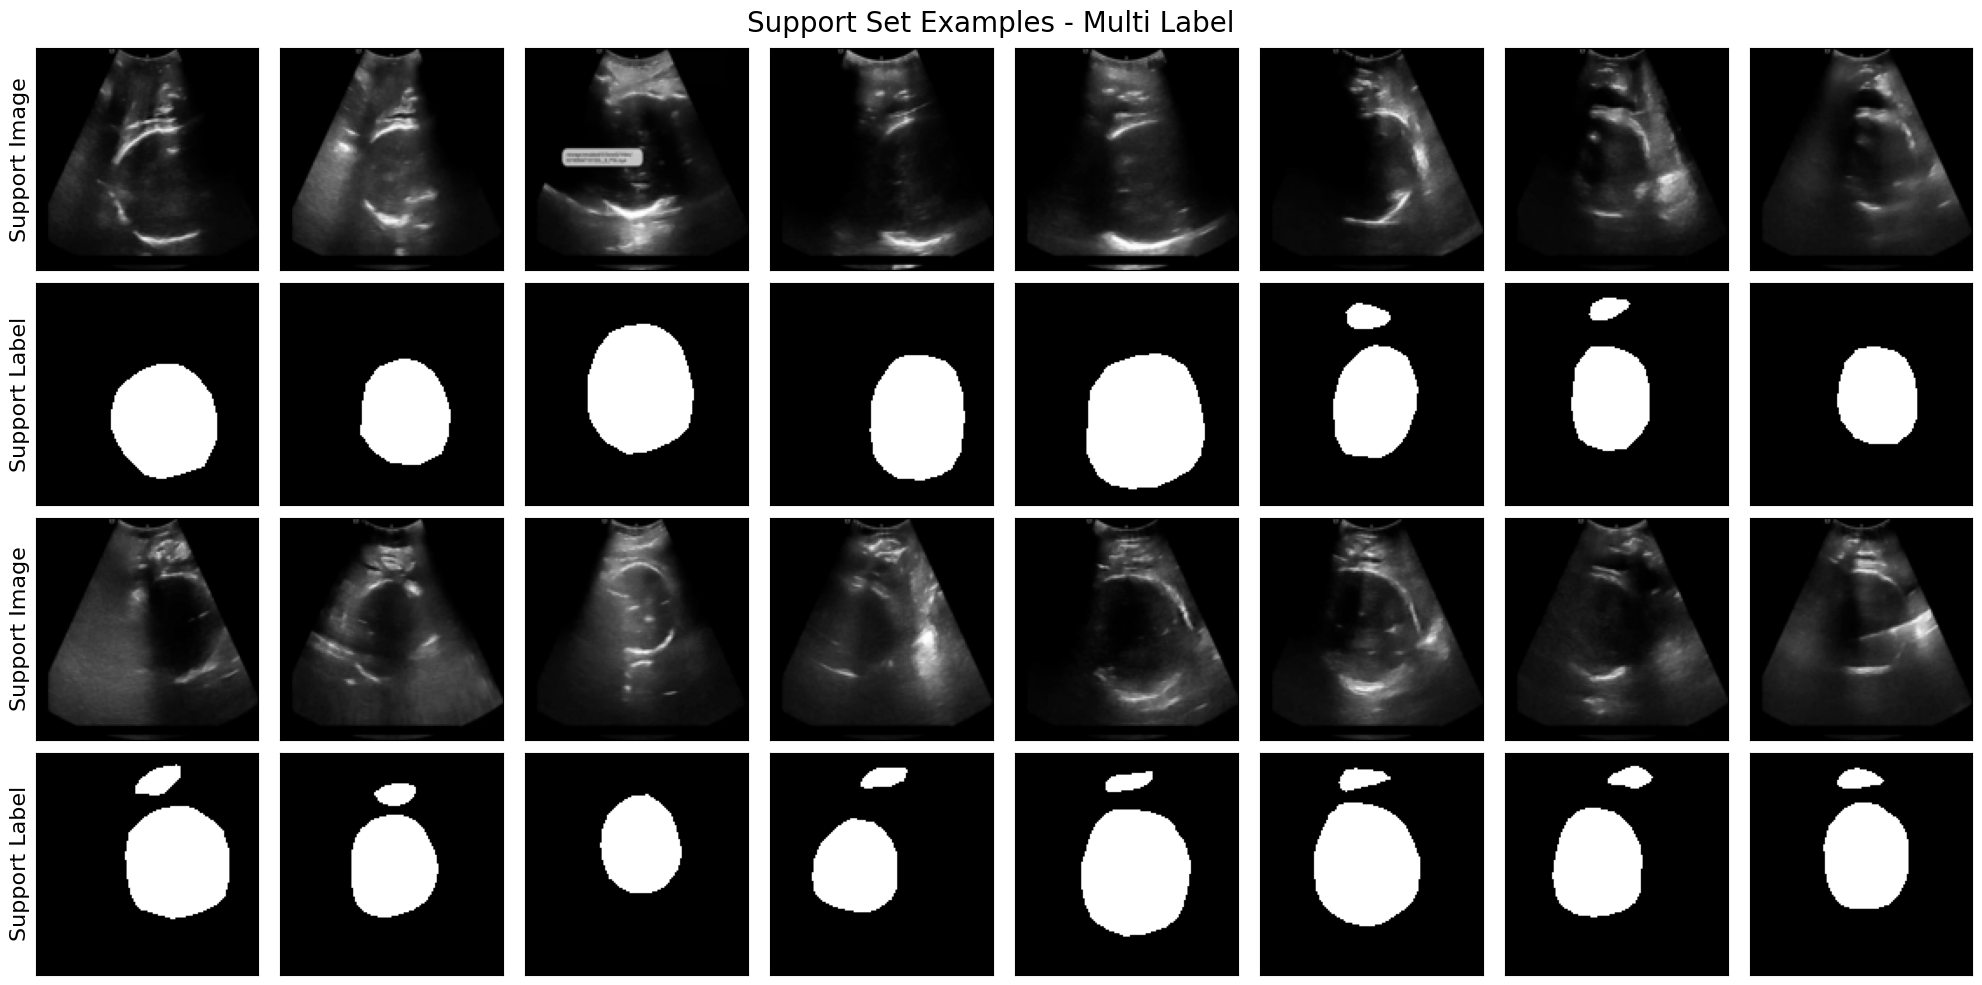

In [81]:
n_viz = 16
visualize_tensors({
    'Support Image': support_images[:n_viz].float(),
    'Support Label': support_labels[:n_viz].float(),
}, 8, title='Support Set Examples - Multi Label')


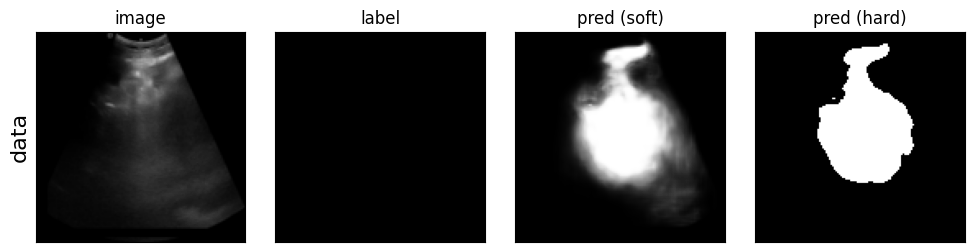

In [96]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

In [99]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [115]:
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


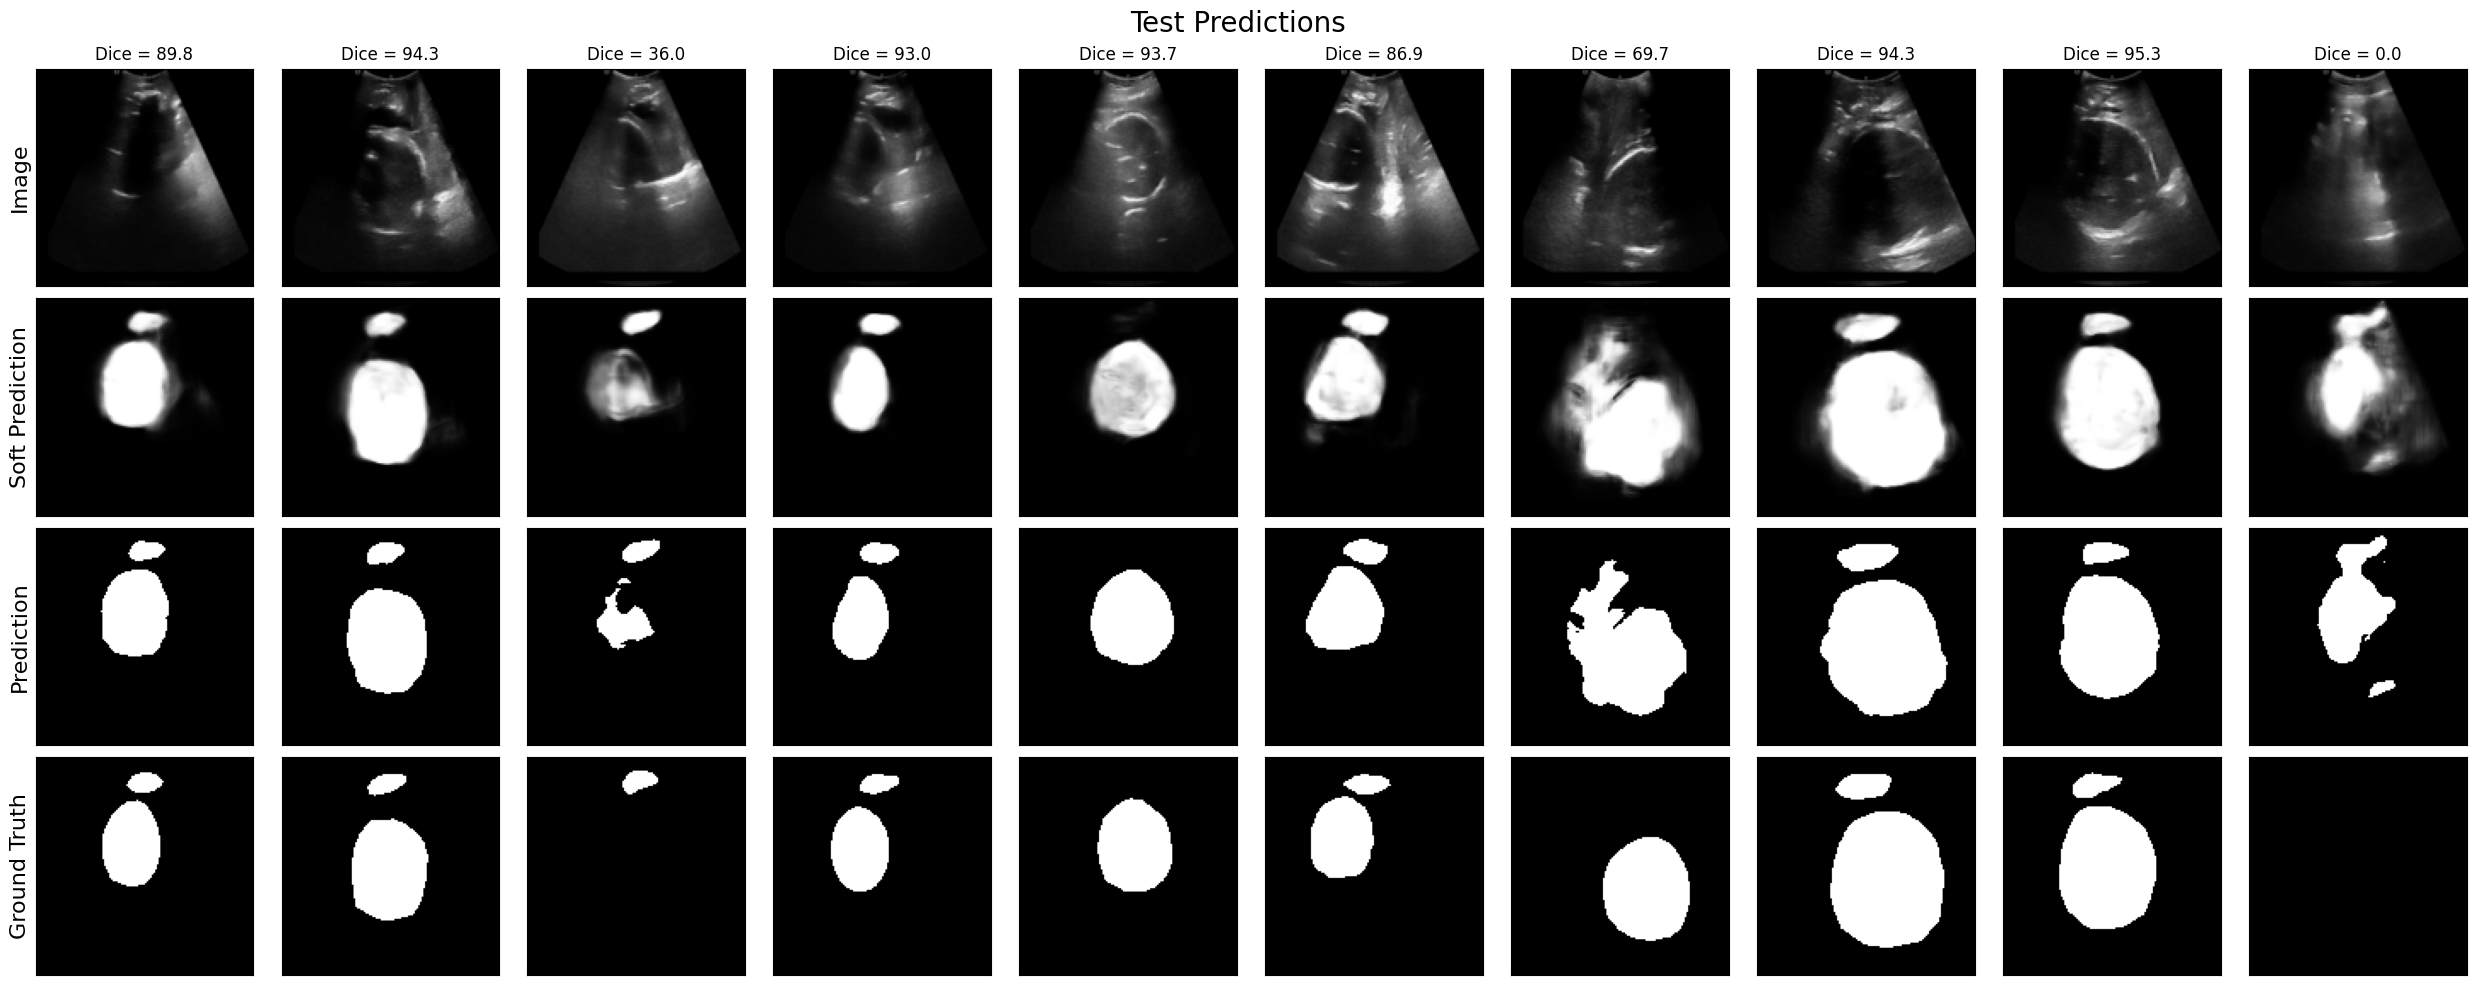

In [101]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

### Images low dice score

In [ ]:
import os
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

def save_low_dice_images(results, filenames, threshold=0.5, output_dir='low_dice_images'):
    """Save images with Dice scores below the threshold."""
    low_dice_scores = []

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save images with low Dice scores
    for i, score in enumerate(results['score']):
        if score < threshold:
            img = results['Image'][i].cpu().numpy().astype(np.float32).squeeze()
            plt.imsave(f'{output_dir}/{filenames[i]}.png', img, cmap='gray')
            low_dice_scores.append(score)

    return low_dice_scores

def process_dataset(dataset, model, support_images, support_labels, threshold=0.5, output_dir='low_dice_images'):
    """Process the entire dataset and save images with low Dice scores."""
    results = defaultdict(list)
    filenames = []
    idxs = np.arange(len(dataset))

    for i in tqdm(idxs):
        image, label = dataset[i]
        filename = dataset.get_filename(i)  # Get the filename
        filenames.append(filename)
        vals = inference(model, image, label, support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)

    # Save and retrieve images with Dice scores below the threshold
    low_dice_scores = save_low_dice_images(results, filenames, threshold=threshold, output_dir=output_dir)

    return low_dice_scores

# Define the threshold
dice_threshold = 0.5

# Define your folders
support_input_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\images\train'
support_mask_folder = r'C:\Users\cinth\Documentos\ams\data_science\actual_thesis\codes\Universeg-main\UniverSeg-main\example_data\partitioned_dataset\masks\train'

# Load the training dataset
d_support = JNU_FMI(support_input_folder, label=support_mask_folder)

# Sample some support images for inference
n_support = 64
support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

# Process the entire training dataset
low_dice_scores_train = process_dataset(d_support, model, support_images, support_labels, threshold=dice_threshold, output_dir='low_dice_images_train')

# Optionally, visualize these low Dice score images for training set
print(f"Number of low Dice score images: {len(low_dice_scores_train)}")


  3%|▎         | 100/3704 [05:23<3:13:24,  3.22s/it]

### Effect of support set size 

In [103]:

n_support = 64

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

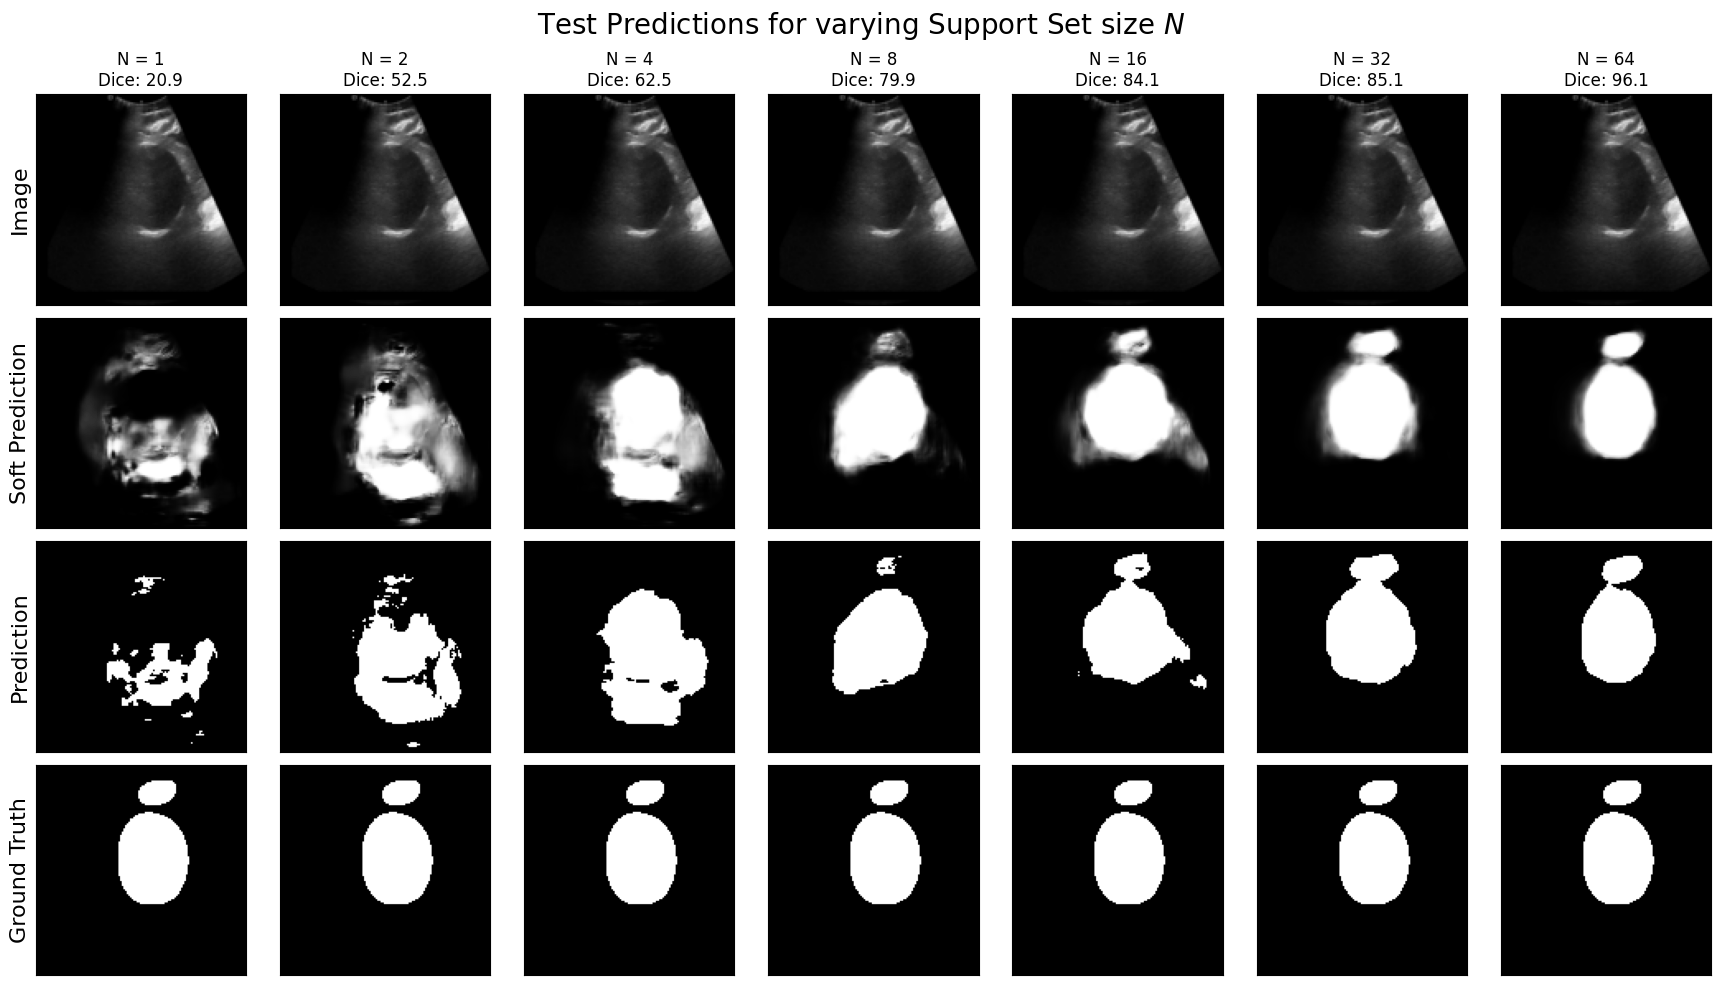

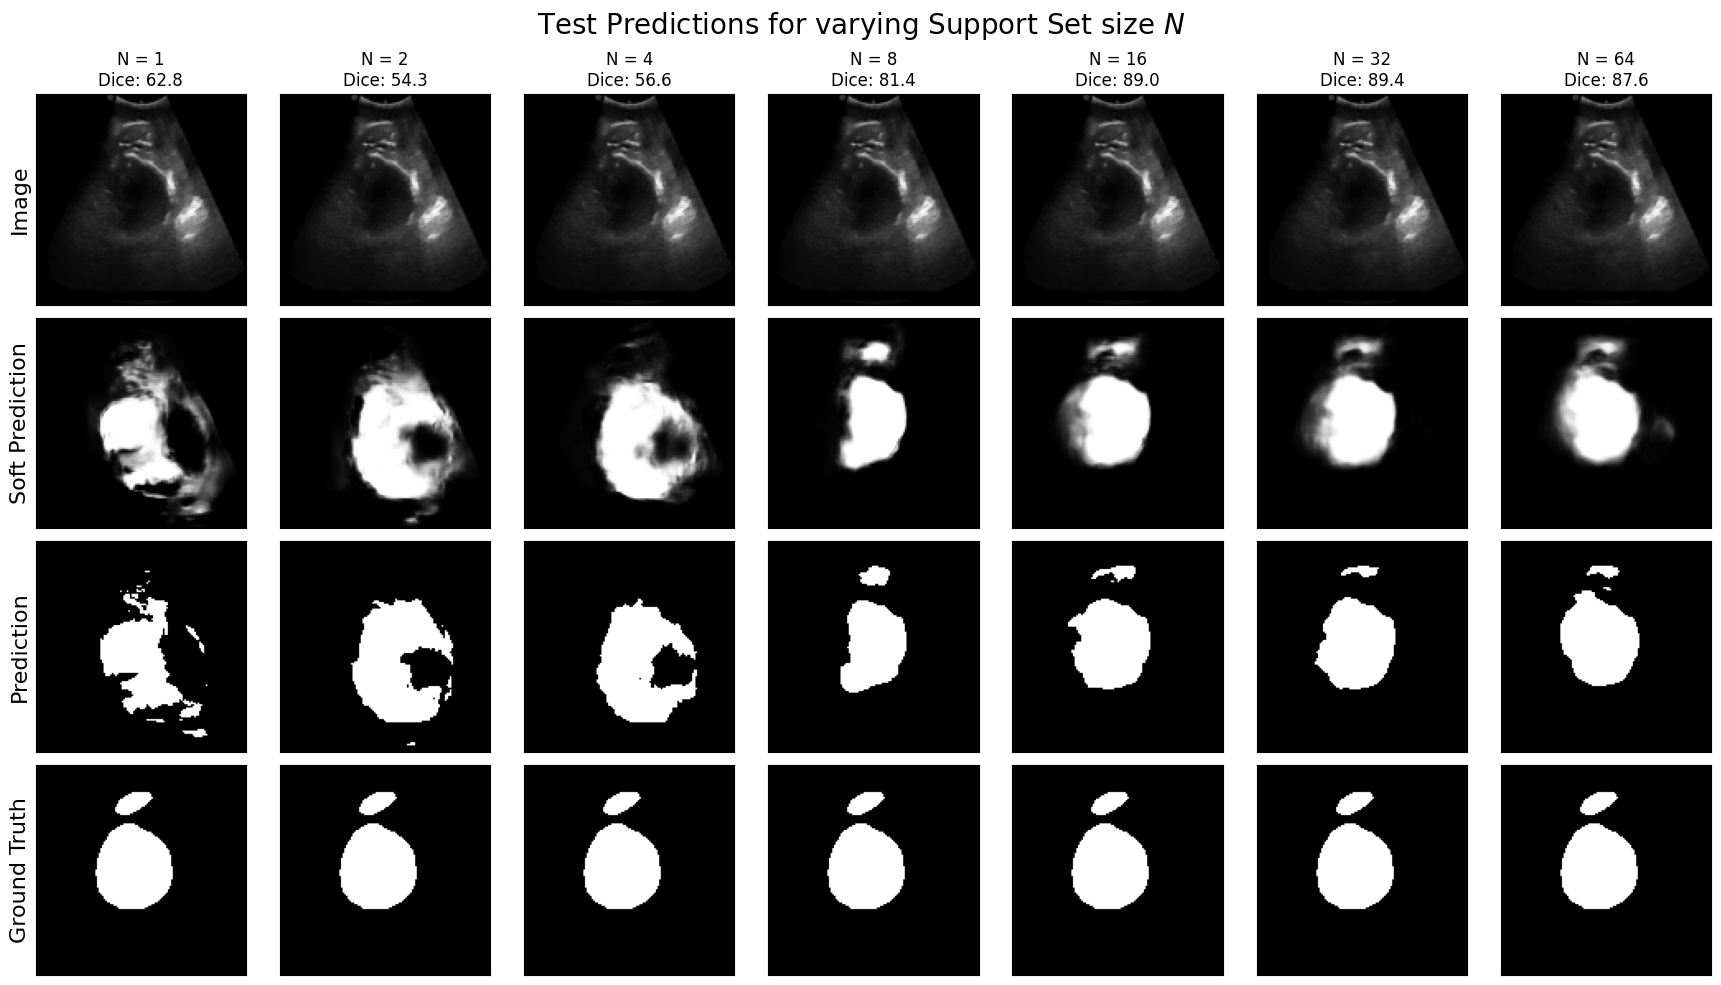

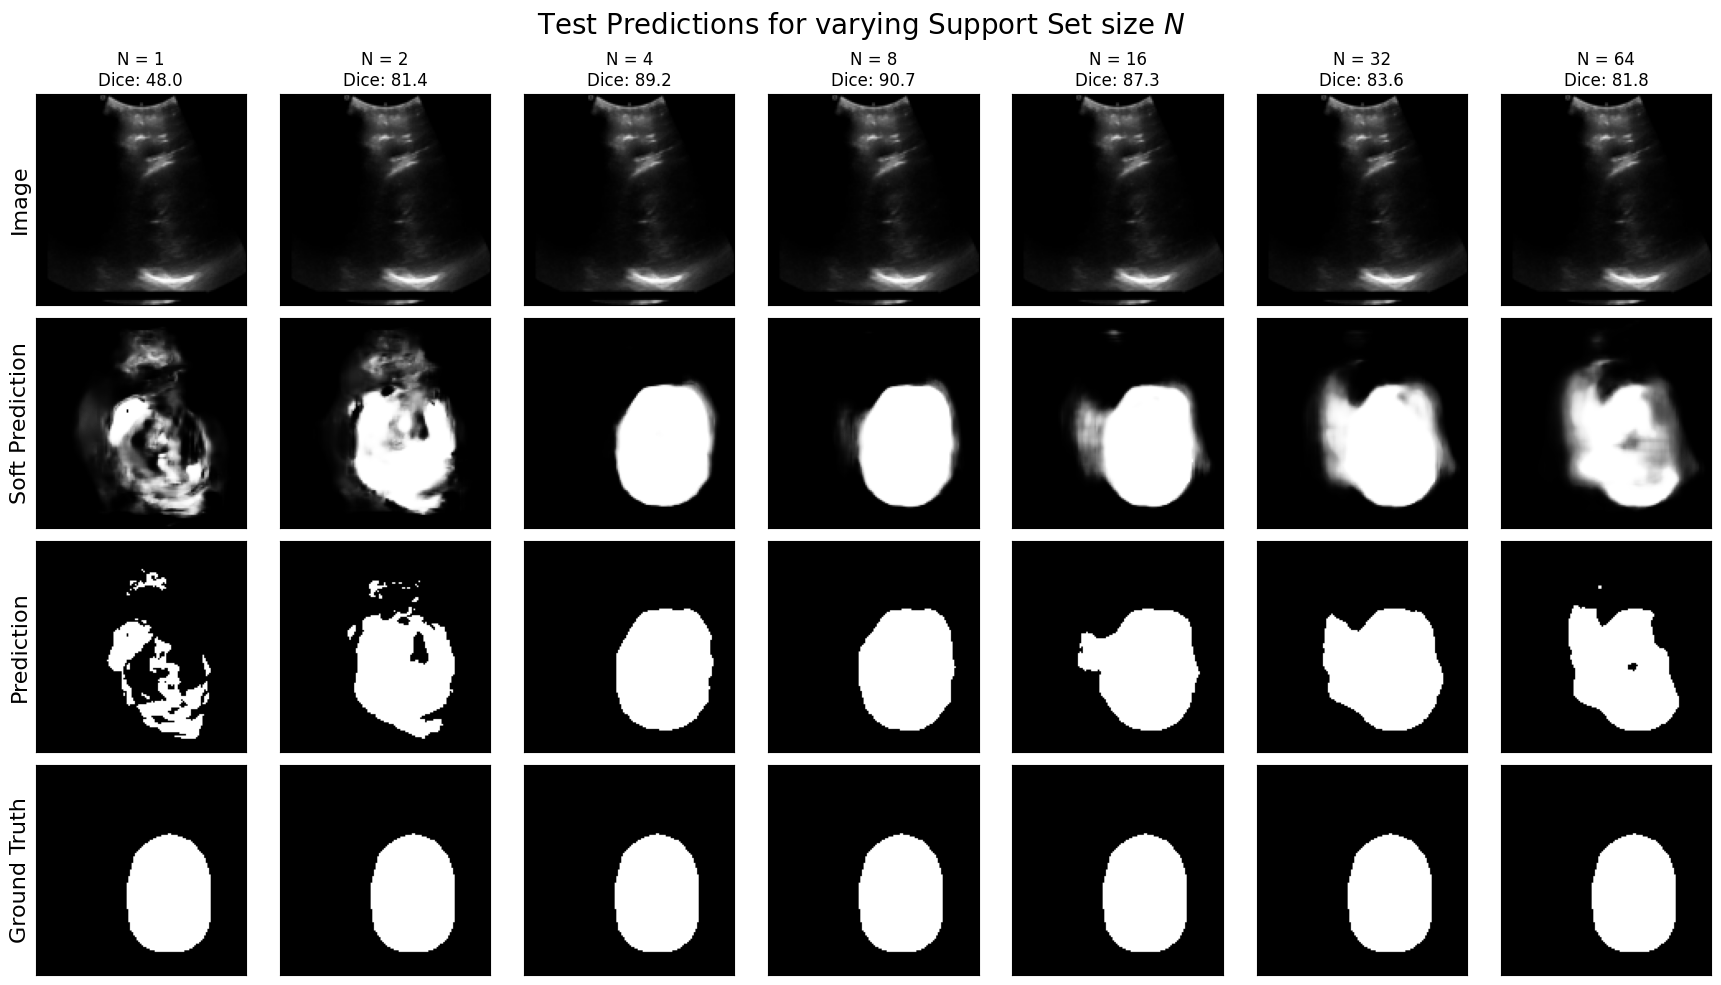

In [104]:
n_predictions = 3
support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))

### Ensembling predictions

In [105]:
# helpful function to sample support data
def sample_support(seed):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0,len(d_support), size=support_size)
    support_images, support_labels = zip(*[d_support[i] for i in idxs])
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return support_images, support_labels

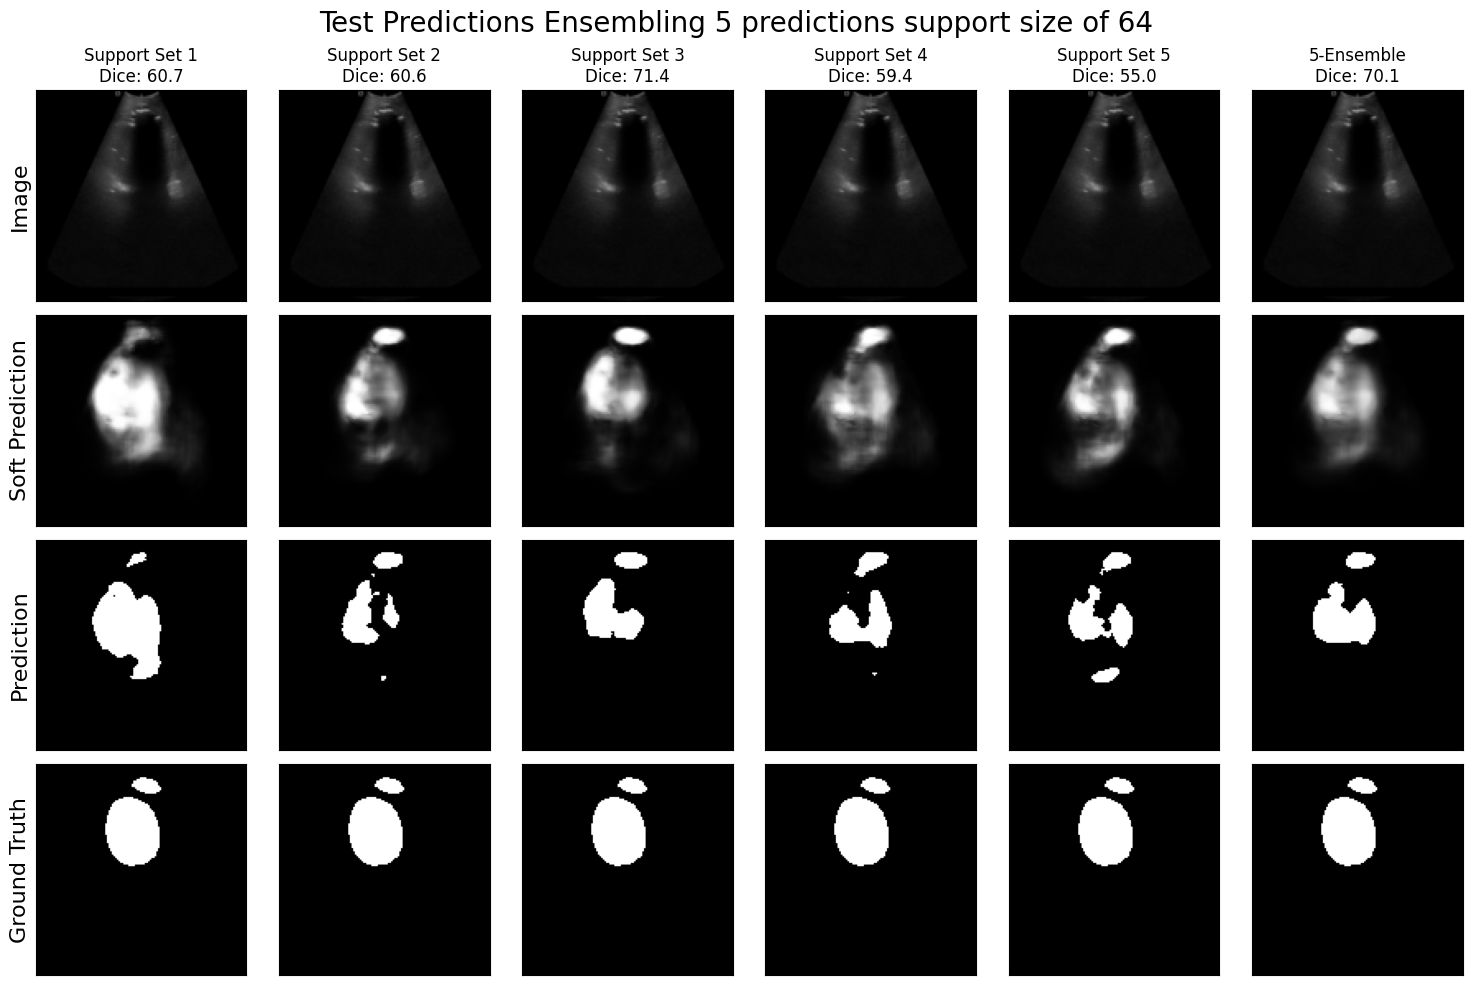

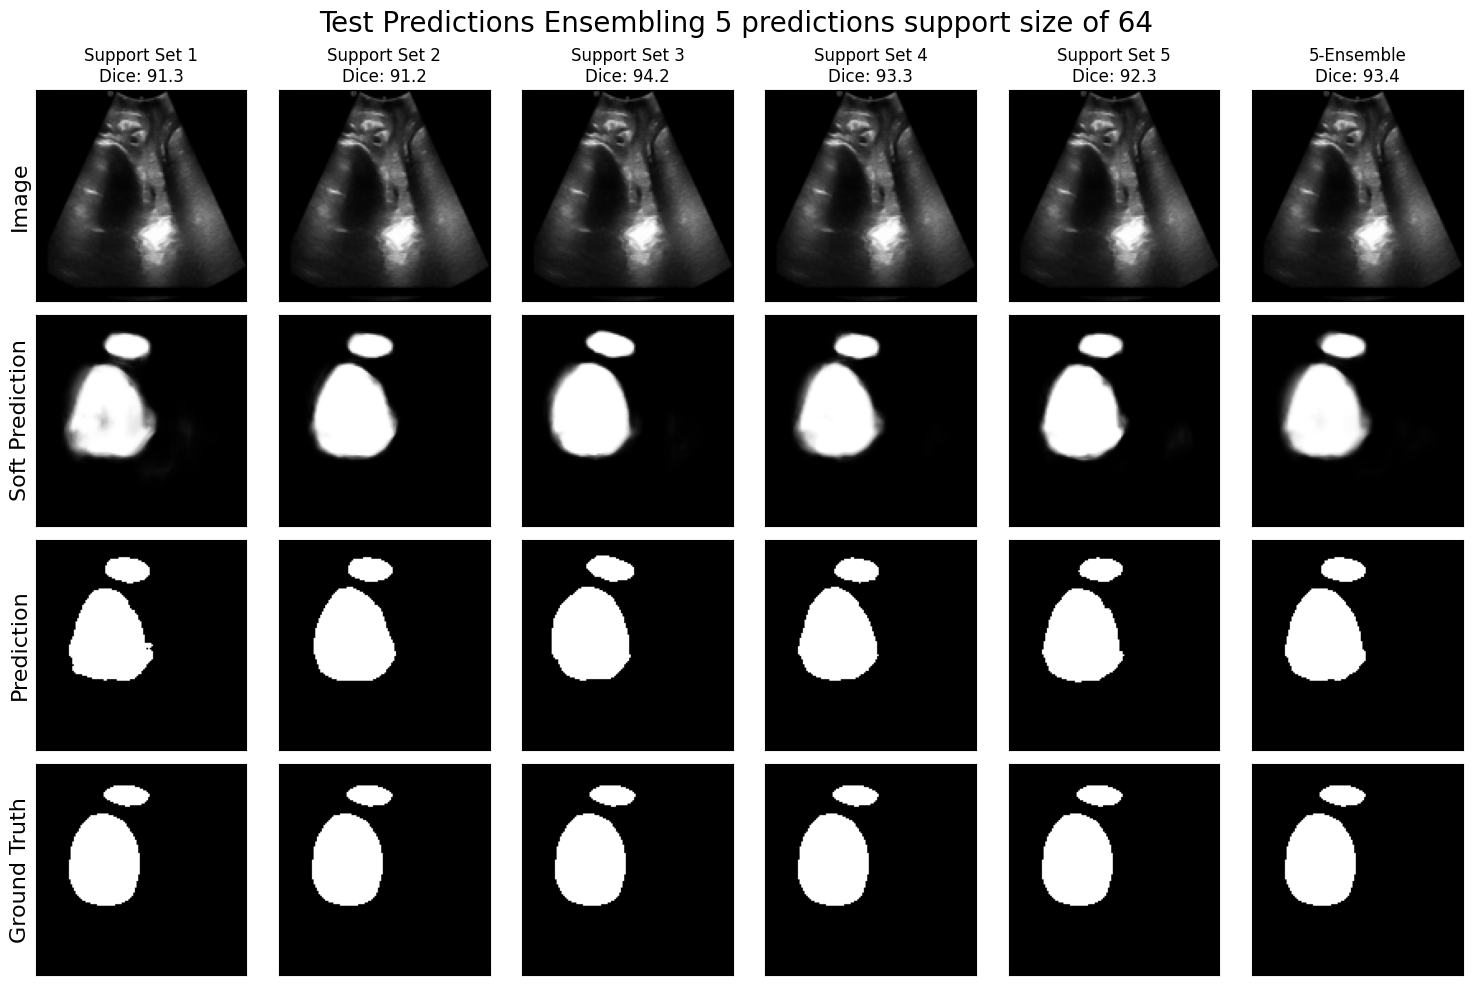

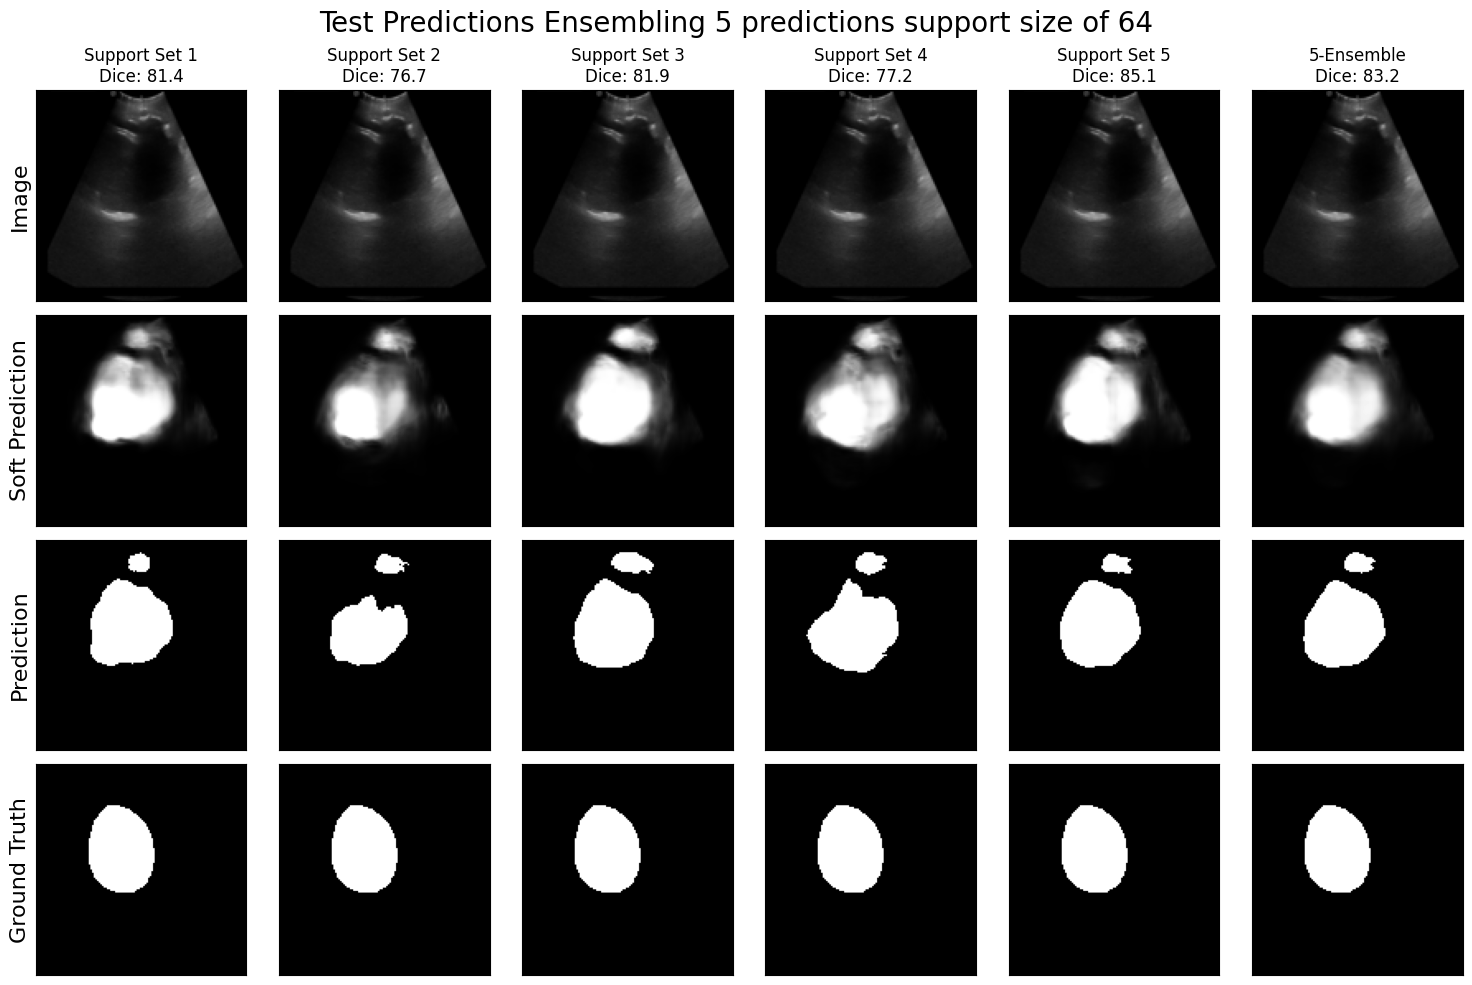

In [109]:
# get support data
# d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
# d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

# setup the number of predictions and ensembling
support_size = 64
n_predictions = 3
n_ensemble = 5

# get various support sets
idxs = np.random.permutation(len(d_test))[:n_predictions]
seeds = range(n_ensemble)
supports = {
    seed: sample_support(seed)
    for seed in range(n_ensemble)
}

# go through the number of experiments
for i in idxs:

    # go through the number of predictions we will ensemble
    results = defaultdict(list)
    for j in range(n_ensemble):
        # get support set and query
        support_images, support_labels = sample_support(j)
        image, label = d_test[i]

        # perform inference
        vals = inference(model, image, label, support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)

    results['Image'].append(image)
    ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
    results['Soft Prediction'].append(ensemble)
    results['Prediction'].append(ensemble.round())
    results['Ground Truth'].append(label)
    results['score'].append(dice_score(ensemble.round(), label.to(device)))

    scores = results.pop('score')
    col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]

    visualize_tensors(results,
                      col_names=col_names,
                      title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}',
                      col_wrap=n_ensemble+1)

### Brightness selection

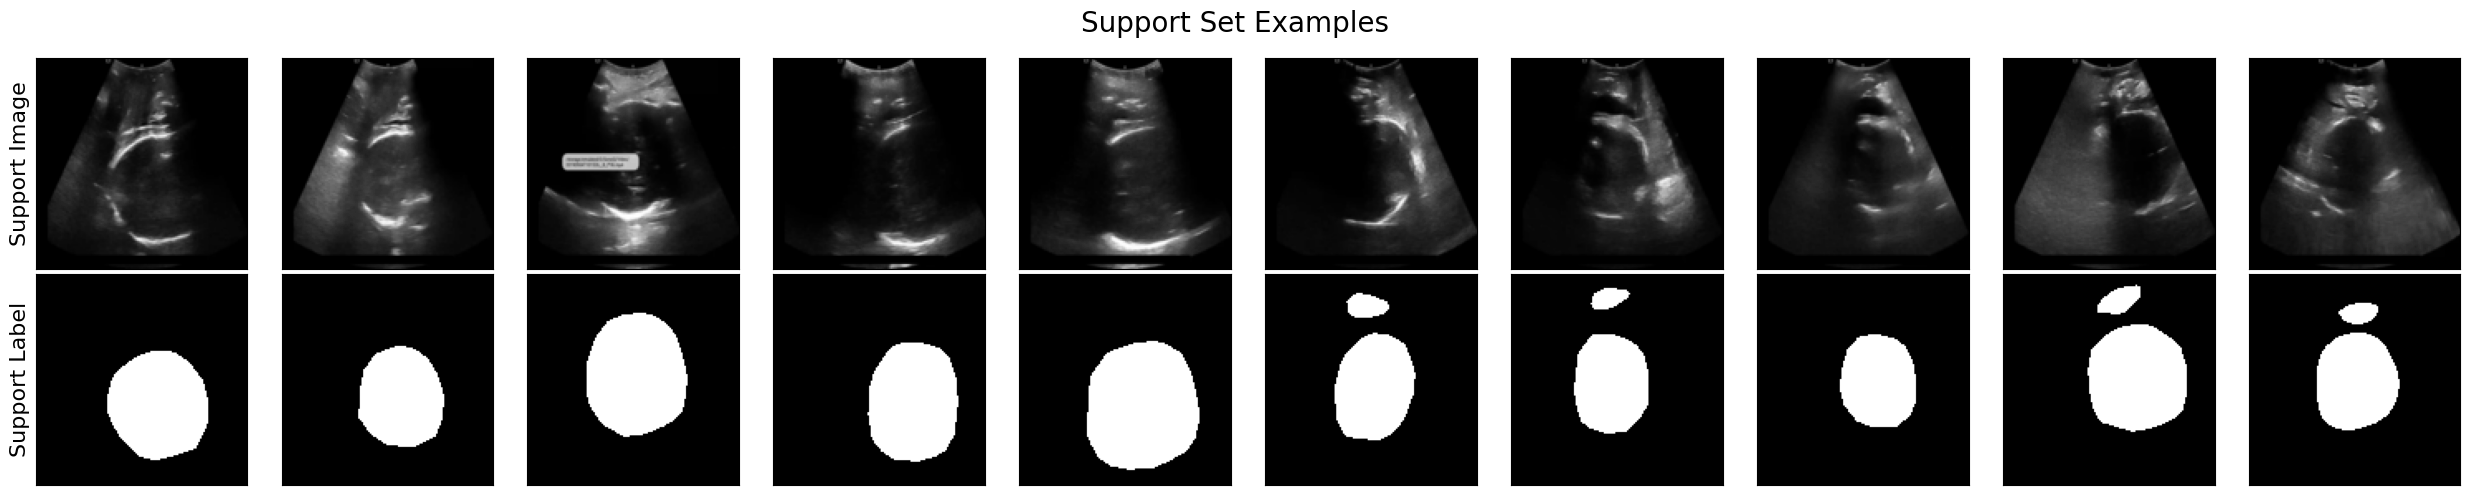

Let's perform inference on a test entry and visualize the prediction

### Inference Analysis


##### Change support labels

In [85]:
# n_support = 64

In [86]:
##changing input not possible at the moment since we only have one dataset

### Effect of the Support Set Size

tensor(4462., device='cuda:0')
tensor(4462., device='cuda:0')
tensor(4462., device='cuda:0')
tensor(4462., device='cuda:0')
tensor(4462., device='cuda:0')
tensor(4462., device='cuda:0')
tensor(4462., device='cuda:0')
tensor(4462., device='cuda:0')
tensor(4462., device='cuda:0')
tensor(4462., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4502., device='cuda:0')
tensor(4494., device='cuda:0')
tensor(4494., device='cuda:0')
tensor(4494., device='cuda:0')
tensor(4494., device='cuda:0')
tensor(4494., device='cuda:0')
tensor(4494., device='cuda:0')
tensor(4494., device='cuda:0')
tensor(4494., device='cuda:0')
tensor(4494., device='cuda:0')
tensor(4494., device='cuda:0')


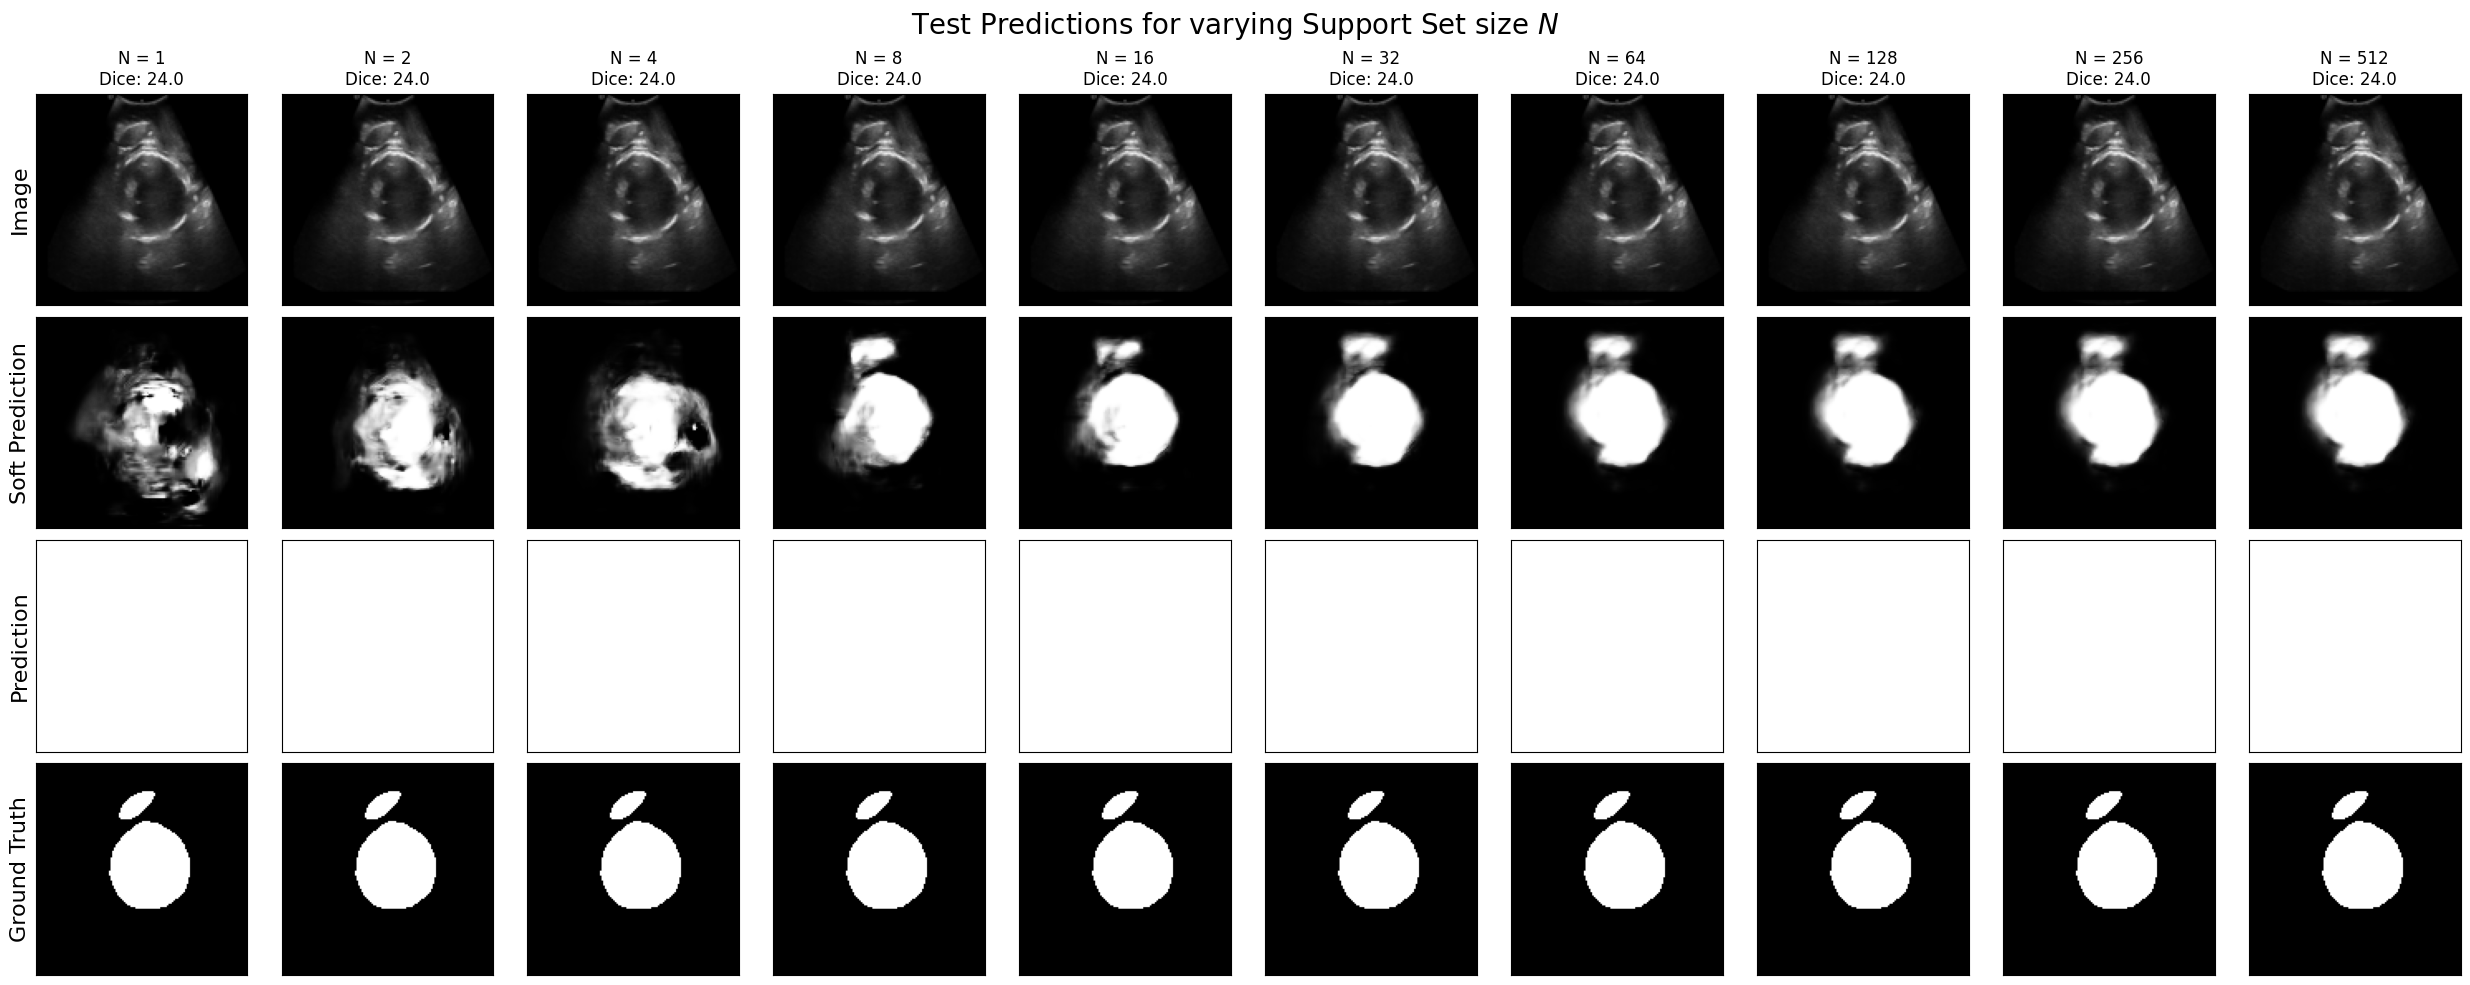

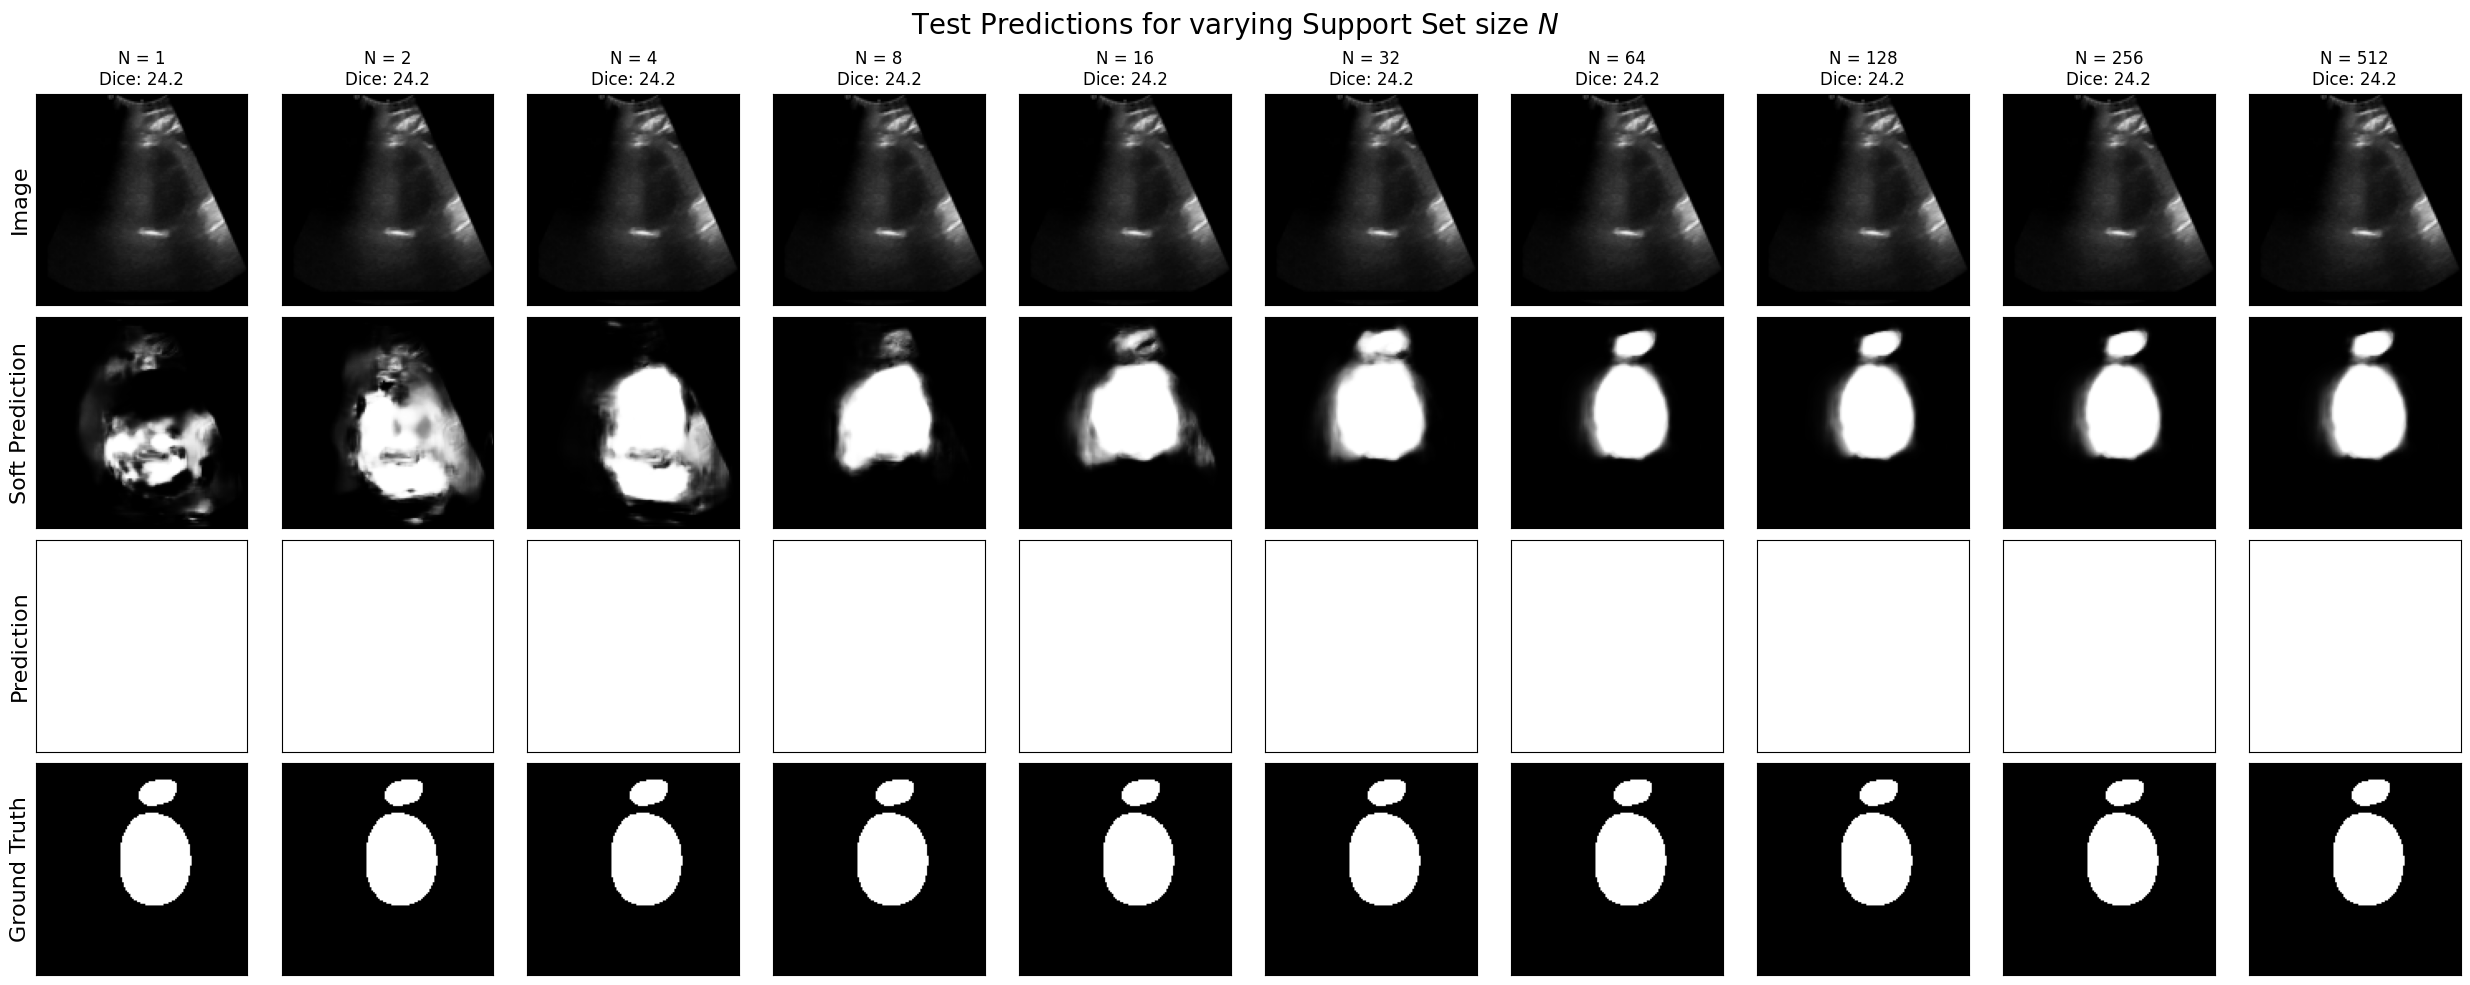

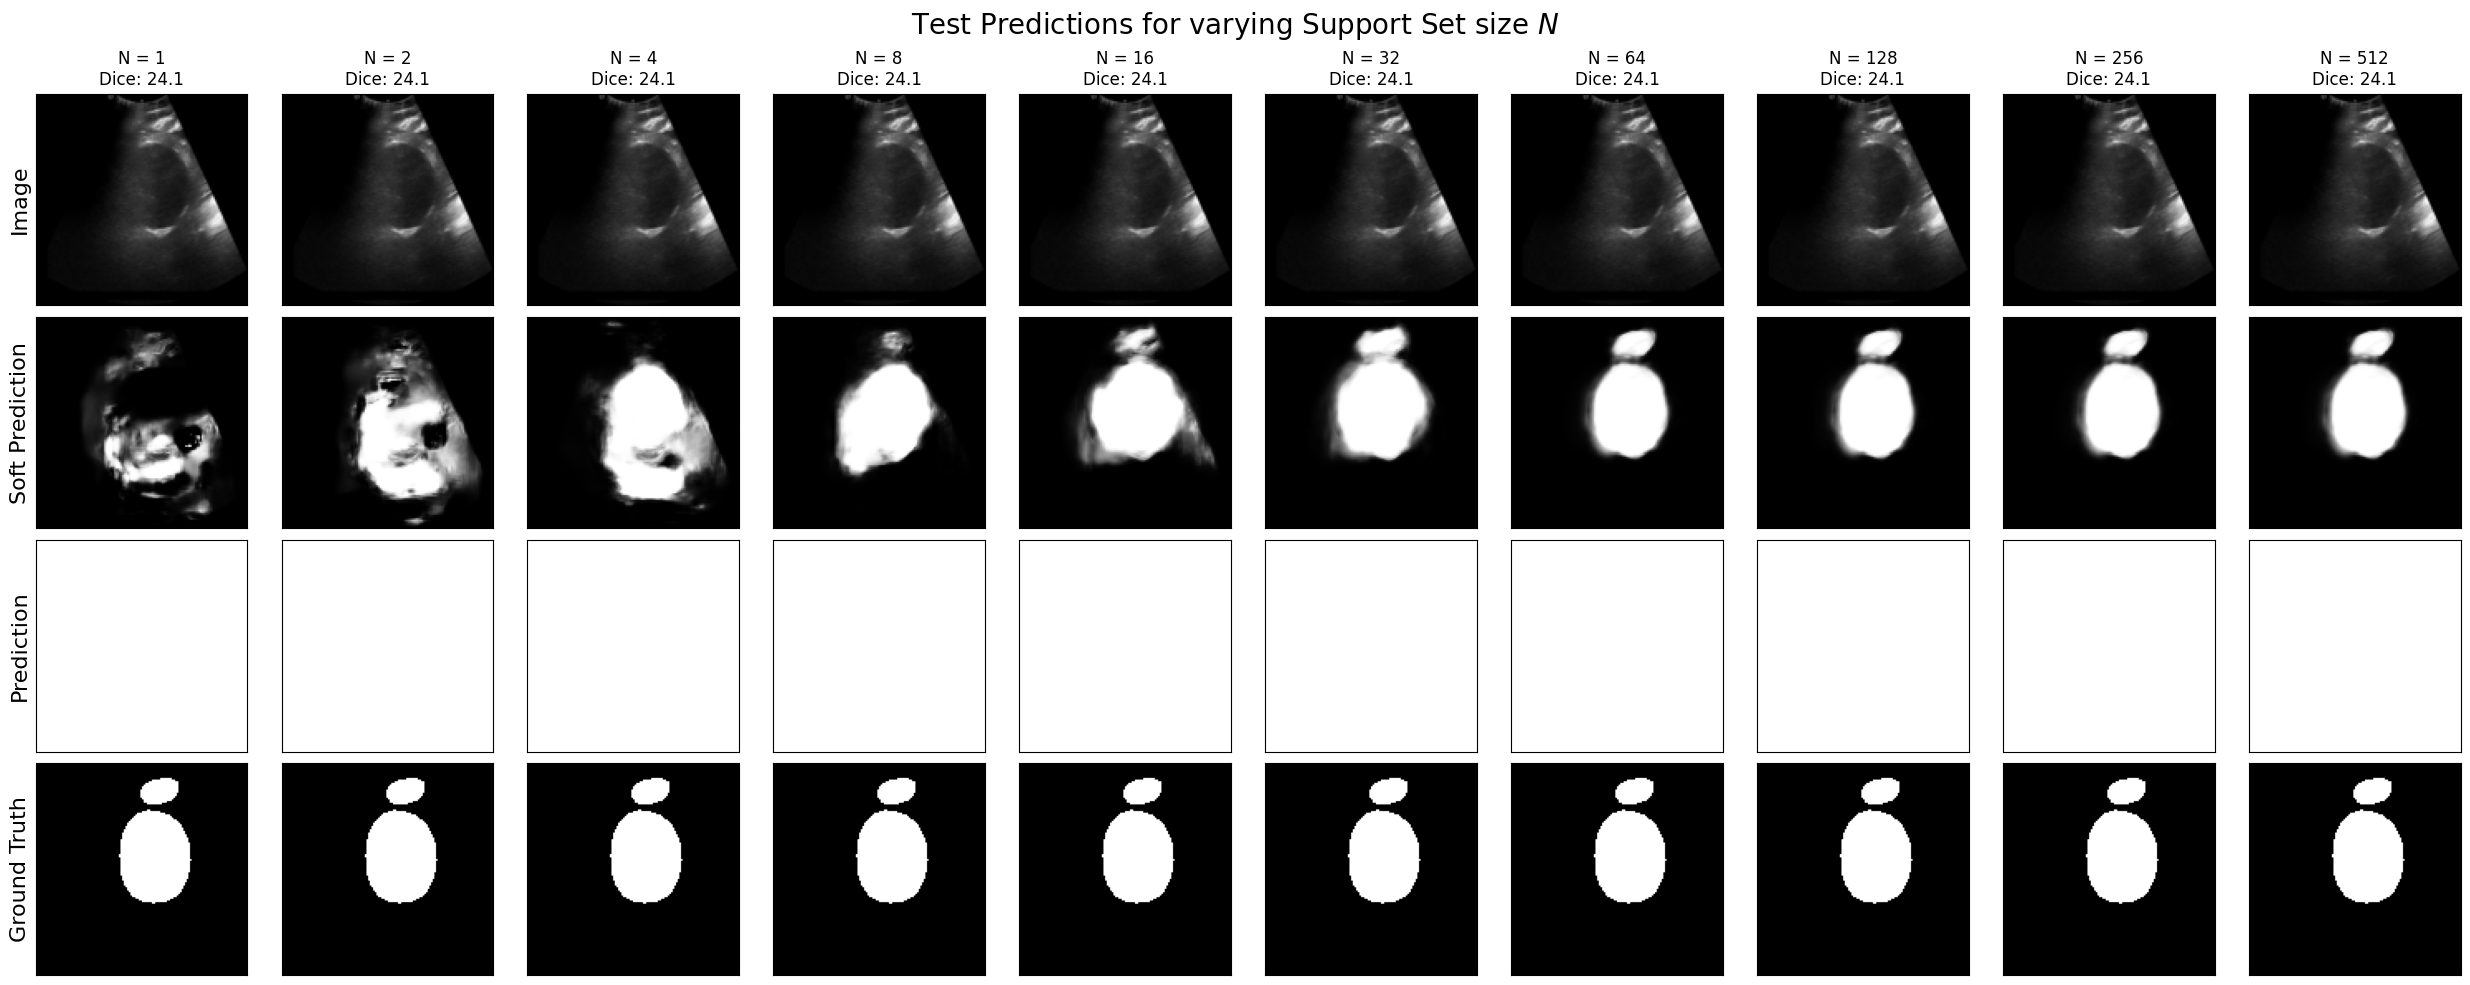

#### Average dice score per support set size

tensor(4344., device='cuda:0')
tensor(4344., device='cuda:0')
tensor(4344., device='cuda:0')
tensor(4344., device='cuda:0')
tensor(4344., device='cuda:0')
tensor(4344., device='cuda:0')
tensor(4344., device='cuda:0')
tensor(4556., device='cuda:0')
tensor(4556., device='cuda:0')
tensor(4556., device='cuda:0')
tensor(4556., device='cuda:0')
tensor(4556., device='cuda:0')
tensor(4556., device='cuda:0')
tensor(4556., device='cuda:0')
tensor(4012., device='cuda:0')
tensor(4012., device='cuda:0')
tensor(4012., device='cuda:0')
tensor(4012., device='cuda:0')
tensor(4012., device='cuda:0')
tensor(4012., device='cuda:0')
tensor(4012., device='cuda:0')
Support Set Size: 1, Average Dice Score: 0.232132226228714
Support Set Size: 2, Average Dice Score: 0.232132226228714
Support Set Size: 4, Average Dice Score: 0.232132226228714
Support Set Size: 8, Average Dice Score: 0.232132226228714
Support Set Size: 16, Average Dice Score: 0.232132226228714
Support Set Size: 32, Average Dice Score: 0.232132226

tensor(5624., device='cuda:0')
tensor(5624., device='cuda:0')
tensor(5624., device='cuda:0')
tensor(5624., device='cuda:0')
tensor(5624., device='cuda:0')
tensor(5624., device='cuda:0')
tensor(5624., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(2566., device='cuda:0')
tensor(2566., device='cuda:0')
tensor(2566., device='cuda:0')
tensor(2566., device='cuda:0')
tensor(2566., device='cuda:0')
tensor(2566., device='cuda:0')
tensor(2566., device='cuda:0')
Average Dice Score for random Test Image 1: 0.2929776906967163
Average Dice Score for random Test Image 2: 0.0
Average Dice Score for random Test Image 3: 0.14524254202842712


In [91]:
##I propose giving an average on the three images as the baseline dice score as option one
#so, you make the average of the scores of n_predictions = 3 or try finding out with other numbers


#### Multi-label Predictions

In [92]:
# d_support = VentricleDataset(support_input_folder, label=None)
# d_test = VentricleDataset(test_input_folder, label=None)
# 
# n_support = 64
# 
# support_images, support_labels = zip(*itertools.islice(d_support, n_support))
# support_images = torch.stack(support_images).to(device)
# support_labels = torch.stack(support_labels).to(device)

### Ensembling Predictions

In [93]:
# # helpful function to sample support data
# def sample_support(seed):
#     rng = np.random.default_rng(seed)
#     idxs = rng.integers(0,len(d_support), size=support_size)
#     support_images, support_labels = zip(*[d_support[i] for i in idxs])
#     support_images = torch.stack(support_images).to(device)
#     support_labels = torch.stack(support_labels).to(device)
#     return support_images, support_labels

In [94]:
# # get support data
# # d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
# # d_test = WBCDataset('JTSC', split='test', label='cytoplasm')
# d_support = VentricleDataset(support_input_folder, label=support_output_pap_folder)
# d_test = VentricleDataset(test_input_folder, label=test_output_pap_folder)
# 
# 
# # setup the number of predictions and ensembling
# support_size = 8
# n_predictions = 3
# n_ensemble = 5
# 
# # get various support sets
# idxs = np.random.permutation(len(d_test))[:n_predictions]
# seeds = range(n_ensemble)
# supports = {
#     seed: sample_support(seed)
#     for seed in range(n_ensemble)
# }
# 
# # go through the number of experiments
# for i in idxs:
# 
#     # go through the number of predictions we will ensemble
#     results = defaultdict(list)
#     for j in range(n_ensemble):
#         # get support set and query
#         support_images, support_labels = sample_support(j)
#         image, label = d_test[i]
# 
#         # perform inference
#         vals = inference(model, image, label, support_images, support_labels)
#         for k, v in vals.items():
#             results[k].append(v)
# 
#     results['Image'].append(image)
#     ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
#     results['Soft Prediction'].append(ensemble)
#     results['Prediction'].append(ensemble.round())
#     results['Ground Truth'].append(label)
#     results['score'].append(dice_score(ensemble.round(), label.to(device)))
# 
#     scores = results.pop('score')
#     col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
#     col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
# 
#     visualize_tensors(results,
#                       col_names=col_names,
#                       title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}',
#                       col_wrap=n_ensemble+1)

In [95]:
##option 2 would be doing same as option one but including ensembling 